[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jensen_and_Nugent_2017/Fig_4_and_7_and_Tab_4_bottom_rows.ipynb) 
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Jensen_and_Nugent_2017/Fig_4_and_7_and_Tab_4_bottom_rows.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Jensen_and_Nugent_2017/Fig_4_and_7_and_Tab_4_bottom_rows.ipynb)

#### based on Fig. 4, Fig.7 and Table 4 (Modified Polluted + GCCN) from [Jensen and Nugent (JAS 74)  "_Condensational Growth of Drops Formed on Giant Sea-Salt Aerosol Particles_"](https://doi.org/10.1175/JAS-D-15-0370.1)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples>=2.45')

In [9]:
from matplotlib import pyplot
import numpy as np

from PySDM_examples.Jensen_and_Nugent_2017 import Settings, Simulation
from open_atmos_jupyter_utils import show_plot
from PySDM_examples.Jensen_and_Nugent_2017.plotting import figure, CLOUD_BASE, find_drop_ids_by_dry_size, compute_table_values
from PySDM.physics import in_unit, si
from IPython.display import display, HTML
from PySDM.physics.constants import PER_CENT

settings = Settings(aerosol="modified polluted", cloud_type="Sc")
simulation = Simulation(settings, gccn=True)

In [3]:
output = simulation.run(steps_per_output_interval= 5)

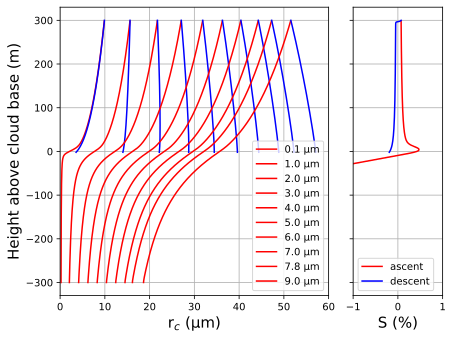

HTML(value="<a href='./Fig_4.pdf' target='_blank'>./Fig_4.pdf</a><br>")

In [4]:
masks = figure(
    output=output,
    settings=settings,
    simulation=simulation,
    plot_drops_with_dry_radii_um=(.1, 1, 2, 3, 4, 5, 6, 7, 8, 9),
    xlim_r_um=(0, 60),
    xlim_S_percent=(-1, 1),
    return_masks=True
)
show_plot("Fig_4.pdf")

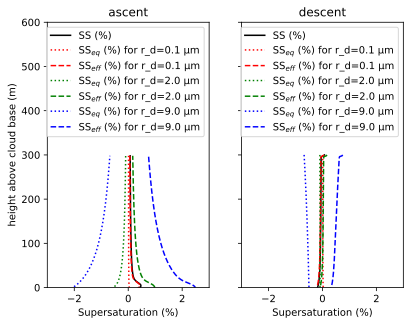

HTML(value="<a href='./Fig_7.pdf' target='_blank'>./Fig_7.pdf</a><br>")

In [5]:
fig, axs = pyplot.subplot_mosaic(
    mosaic=[["ascent", "descent"]],
    width_ratios=[1, 1],
    sharex=True,
    sharey=True,
    
)
height_above_cloud_base = np.asarray(output["products"]["z"]) - settings.z0 - CLOUD_BASE
SS = np.asarray(output["products"]["S_max"])
SS_eq = {}
SS_ef = {}
for mask_label, mask in masks.items():
    axs[mask_label].plot(
        in_unit(SS, PER_CENT)[mask],
        height_above_cloud_base[mask],
        color='black',
        label='SS (%)'
    )
    dry_radii_um = (0.1, 2, 9)
    colors = ('red', 'green', 'blue')
    for i, drop_id in enumerate(find_drop_ids_by_dry_size(
            plot_drops_with_dry_radii_um=dry_radii_um,
            simulation_r_dry=simulation.r_dry
    )):
        SS_eq[dry_radii_um[i]] = np.asarray(output["attributes"]["equilibrium supersaturation"][drop_id]) - 1
        label_suffix = f' for r_d={in_unit(simulation.r_dry[drop_id], si.um):.2} µm'
        axs[mask_label].plot(
            in_unit(SS_eq[dry_radii_um[i]], PER_CENT)[mask],
            height_above_cloud_base[mask],
            label='SS$_{eq}$ (%)' + label_suffix,
            linestyle=':',
            color=colors[i]
        )
        SS_ef[dry_radii_um[i]] = SS - SS_eq[dry_radii_um[i]]
        axs[mask_label].plot(
            in_unit(SS-SS_eq[dry_radii_um[i]], PER_CENT)[mask],
            height_above_cloud_base[mask],
            label='SS$_{eff}$ (%)' + label_suffix,
            linestyle='--',
            color=colors[i]
        )

    axs[mask_label].set_title(mask_label)
    axs[mask_label].set_xlim(-3, 3)
    axs[mask_label].set_ylim(0, 600)
    axs[mask_label].legend()
    axs["ascent"].set_ylabel("height above cloud base (m)")
    axs["ascent"].set_xlabel("Supersaturation (%)")
    axs["descent"].set_xlabel("Supersaturation (%)")
    
show_plot("Fig_7.pdf")

In [6]:
table_values = compute_table_values(
    height_above_cb_m = (50, 100, 150, 200, 250, 300),
    height_cb_m = 900,
    products=output["products"],
    ascent_mask = masks["ascent"],
)  

In [7]:
table_html = "<table>"
table_html += """
  <tr style="border-bottom:1px black solid">
    <th > Aerosols </th>
    <th > z (m) </th>
    <th>Mean cloud drop radius (μm)</th>
    <th>Drop spectral width (μm)</th>
    <th>Drop dispersion</th>
  </tr>  
"""
row_labels = {
    'ascent': 'Mod.polluted + GCCN (Updraft)',
    'descent': 'Mod.polluted + GCCN (Downdraft)'
}

for case, data in table_values.items():
    for var in data:  
        table_html += f"""
          <tr{' style="border-top:1px black solid"'}>
            <td>{row_labels[case]}</td>
            <td>{var[0]}</td>
            <td>{var[1]}</td>
            <td>{var[2]}</td>
            <td>{var[3]}</td>
          </tr>   
        """   

table_html += "</table>"

In [8]:
display(HTML(table_html))

Aerosols,z (m),Mean cloud drop radius (μm),Drop spectral width (μm),Drop dispersion
Mod.polluted + GCCN (Updraft),50,5.44,0.44,0.082
Mod.polluted + GCCN (Updraft),100,6.74,0.40,0.059
Mod.polluted + GCCN (Updraft),150,7.67,0.37,0.049
Mod.polluted + GCCN (Updraft),200,8.42,0.35,0.042
Mod.polluted + GCCN (Updraft),250,9.05,0.34,0.038
Mod.polluted + GCCN (Updraft),300,9.60,0.33,0.034
Mod.polluted + GCCN (Downdraft),300,9.60,0.33,0.034
Mod.polluted + GCCN (Downdraft),250,9.07,0.35,0.039
Mod.polluted + GCCN (Downdraft),200,8.44,0.38,0.045
Mod.polluted + GCCN (Downdraft),150,7.69,0.42,0.054
